<a href="https://colab.research.google.com/github/SEHWAJO/MyProject/blob/main/%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8_%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8_%EB%AA%A8%EB%8D%B8_%EB%A7%8C%EB%93%A4%EA%B8%B0_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 코비 브라이언트의 슛 성공 여부 예측해보기

이번 스프린트 챌린지에서는 故 코비 브라이언트 선수의 NBA 필드 골 시도들이 담긴 데이터셋을 다룹니다 (1996년 11월 3일부터 2016년 4월 13일까지의 정규 시즌과 플레이오프 시즌 기록).

여러분은 각 슛의 성공 여부를 슈팅의 대한 정보, 게임에 대한 정보를 통해서 예측해야 합니다. 이것은 상당히 어려운 예측입니다. 해당 데이터셋은 [NBA API]((https://github.com/swar/nba_api) 파이썬 라이브러리를 통해 수집 됐습니다. 

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [3]:
# 데이터셋을 불러옵니다
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

In [4]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season
2,29600044,124,Kobe Bryant,2,8,37,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,1996-11-06,CHH,LAL,Regular Season
3,29600044,144,Kobe Bryant,2,6,34,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,1996-11-06,CHH,LAL,Regular Season
4,29600044,151,Kobe Bryant,2,5,27,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,1996-11-06,CHH,LAL,Regular Season


In [5]:
# 살펴보기
df.isnull().sum()

game_id              0
game_event_id        0
player_name          0
period               0
minutes_remaining    0
seconds_remaining    0
action_type          0
shot_type            0
shot_zone_basic      0
shot_zone_area       0
shot_zone_range      0
shot_distance        0
loc_x                0
loc_y                0
shot_made_flag       0
game_date            0
htm                  0
vtm                  0
season_type          0
dtype: int64

# Part 1 - Data Preprocessing

## 1.1 분류를 위한 베이스라인 정확도를 계산하세요
>예측 해야하는 target은 `shot_made_flag` 입니다. 전체 데이터를 써서 baseline **accuracy score**를 계산하세요.

In [6]:
target = 'shot_made_flag'

y = df[target]

# 기준 모델 확인
y.value_counts(normalize=True)

0    0.552692
1    0.447308
Name: shot_made_flag, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


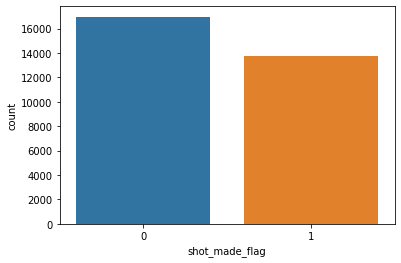

In [7]:
#타겟 비율 시각화
import seaborn as sns
sns.countplot(y);

In [8]:
#기준모델 생성
major = y.mode()[0]
y_pred = [major]*len(y)

#기준모델 정확도 확인
from sklearn.metrics import accuracy_score
print('basline accuracy score:',accuracy_score(y, y_pred))

basline accuracy score: 0.5526924455158485


## 1.2 모델의 예측 정확도를 시험하기 위한 test set을 만드세요.

> 예측 모델 시험을 위해 **2014-15** ~ **2015-16** 시즌을 `test set`으로 만듭니다. NBA 시즌은 **10월**에 시작해서 **6월**에 종료합니다. 테스트셋에 **1826개**의 데이터가 있다면 알맞게 분할한 것입니다.

In [9]:
# 확인 
df['game_date']

0        1996-11-03
1        1996-11-05
2        1996-11-06
3        1996-11-06
4        1996-11-06
            ...    
30692    2016-04-13
30693    2016-04-13
30694    2016-04-13
30695    2016-04-13
30696    2016-04-13
Name: game_date, Length: 30697, dtype: object

In [10]:
df['game_date'] = pd.to_datetime(df['game_date'])

mask_test = (df['game_date'] >= '2014-10-01') & (df['game_date'] <= '2016-06-30')

test = df[mask_test]
train = df[~mask_test]

train.shape, test.shape

((28871, 19), (1826, 19))

## 1.3 새로운 feature를 만드세요

>- **Opponent**: LA Lakers를 상대하는 팀을 나타내는 feature
>- **Made previous shot**: 코비 브라이언트의 예전 슛이 성공했는지 여부
    

In [11]:
df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'htm', 'vtm',
       'season_type'],
      dtype='object')

In [12]:
def feature_engineering(df):
    df_tmp = df.copy()
    
    # Opponent
    df_tmp['opponent'] = (df_tmp['htm'] + df_tmp['vtm']).str.replace('LAL','')
    
    # Made previous shot
    df_tmp['made_previous_shot'] = ''
    for i in range(len(df_tmp)):
        if i == 0:
            df_tmp['made_previous_shot'].iloc[i] = df_tmp[target].iloc[i]
        else:
            df_tmp['made_previous_shot'].iloc[i] = df_tmp[target].iloc[i-1]
            
    # 불필요한 컬럼 제거
    delet_col = ['game_date' ,'game_event_id', 'player_name','period','minutes_remaining', 'seconds_remaining', 'htm', 'vtm']
    df_tmp.drop(delet_col, axis = 1, inplace = True)
    
    return df_tmp

In [13]:
X_train = feature_engineering(train)
X_test = feature_engineering(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
X_train.head()

,game_id,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,season_type,opponent,made_previous_shot
0,29600027,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,Regular Season,MIN,0
1,29600031,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,Regular Season,NYK,0
2,29600044,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,Regular Season,CHH,0
3,29600044,Jump Shot,3PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,0,0,Regular Season,CHH,1
4,29600044,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,13,-10,138,1,Regular Season,CHH,0


In [15]:
X_test.head()

,game_id,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,season_type,opponent,made_previous_shot
28871,21400003,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,20,-54,201,0,Regular Season,HOU,0
28872,21400003,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,-16,63,1,Regular Season,HOU,0
28873,21400003,Turnaround Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,18,166,78,0,Regular Season,HOU,1
28874,21400003,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,27,-138,241,0,Regular Season,HOU,0
28875,21400003,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-179,88,0,Regular Season,HOU,0


## 1.4 모델을 어떻게 검증할지 결정한 후에 데이터셋을 분할하세요. 

>아래의 검증 방법 중 하나를 선택한 후 목적에 맞게 데이터를 분할 하세요. 어떤 방법을 선택하는지 여부로 채점되지 않습니다 (두 방법 모두 좋은 방법입니다).
>
>- **Train/validate/test split을 통한 검증 (Hold-out Validation): 무작위로 80/20% 비율로 나누기**
>- **독립적인 test set으로 Cross-validation을 통한 검증**. scikit-learn에 있는 모든 cross-validation 방법을 활용하셔도 됩니다.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X_train, test_size=0.2,random_state=2)

In [17]:
# train
y_train = X_train[target]
X_train = X_train.drop(target, axis=1)

In [18]:
# validation
y_val = X_val[target]
X_val = X_val.drop(target, axis=1)

In [19]:
# test
y_test = X_test[target]
X_test = X_test.drop(target, axis=1)

In [20]:
X_train.shape, X_test.shape

((23096, 12), (1826, 12))

# Part 2 - Modeling & Evaluation

## 2.1 범주형 feature를 인코딩하고 DecisionTree 혹은 RandomForest를 이용한 학습까지 완료하는 파이프라인을 구축하세요
>Scikit-learn의 `pipeline`을 활용합니다.

In [21]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from category_encoders import OrdinalEncoder, OneHotEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'season_type',
                                      'opponent', 'made_previous_shot'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                          1
Tip Shot                           2
Layup Shot                         3...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',


## 2.2 검증셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요.
>1.4에서 Cross-validation으로 진행한 경우는 그냥 cv score를 작성하세요.

In [23]:
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))
print('----------')
print('훈련 정확도(f1_score):', f1_score(y_train, y_train_pred))
print('검증 정확도(f1_score):', f1_score(y_val, y_val_pred))

훈련 정확도:  0.9862313820574992
검증 정확도:  0.6460606060606061
----------
훈련 정확도(f1_score): 0.9846968238691048
검증 정확도(f1_score): 0.5729210196406184


## 2.3 테스트셋을 사용해서 모델의 예측 정확도(accuracy score)를 계산하세요

In [24]:
y_test_pred = pipe.predict(X_test)

print('test 정확도: ', pipe.score(X_test, y_test))
print('test 정확도(f1_score):', f1_score(y_test, y_test_pred))

test 정확도:  0.6511500547645126
test 정확도(f1_score): 0.5305821665438467


# Part 3 - Confusion Matrix
### 다음 confusion matrix를 사용해서 accuracy, precision, recall을 계산하세요. 아래의 테이블이 이진분류 모델의 confusion matrix라고 생각하고 계산하세요.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2" align='center'><b>Predicted</b></td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
      <td rowspan="2"><b>Actual</b></td>
    <td>Negative</td>
    <td style="border: solid" align='center'>85</td>
    <td style="border: solid" align='center'>58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid" align='center'>8</td>
    <td style="border: solid" align='center'> 36</td>
  </tr>
</table>

In [25]:
tp = 36
tn = 85
fp = 58
fn = 8
total = tp + tn + fp + fn

### a) Accuracy score를 계산하세요

In [26]:
real_positives = tp + tn
accuracy=real_positives/total

accuracy

0.6470588235294118

### b) Precision score를 계산하세요 

In [27]:
positives = tp + fp
precision=tp/positives

precision

0.3829787234042553

### c) Recall score를 계산하세요

In [28]:
real_positives = tp + fn
recall=tp / real_positives

recall

0.8181818181818182